# Подключаем необходимые библиотеки

In [223]:
!pip install tqdm
!pip install scikit-learn
!pip install catboost --no-cache-dir
!pip install torch
!pip install -U lightautoml

In [224]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
import catboost as cb
import os, shutil, pickle
from collections import defaultdict
import torch
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task
from datetime import datetime
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

# Загрузка и обработка данных

In [247]:
df = pd.read_csv('personal_transactions_data.csv', names=['date', 'description', 'sum', 'tr', 'cat', 'name'], sep=",")
df = df[1:]
df = df[df['tr'] == 'debit']
df = df[['date', 'sum']]
df['sum'] = df['sum'].astype('float')
df

,date,sum
1,01/01/2018,11.11
2,01/02/2018,1247.44
3,01/02/2018,24.22
5,01/04/2018,11.76
6,01/05/2018,25.85
...,...,...
799,09/23/2019,24.63
801,09/28/2019,33.46
802,09/28/2019,4.27
803,09/30/2019,1.75


In [248]:
def prepoc(df):
    df = df[df['date'].notna()]
    df = df[df['sum'].notna()]
    df['date'] = pd.to_datetime(df['date'])
    
    return df
df = prepoc(df)
df

,date,sum
1,2018-01-01,11.11
2,2018-01-02,1247.44
3,2018-01-02,24.22
5,2018-01-04,11.76
6,2018-01-05,25.85
...,...,...
799,2019-09-23,24.63
801,2019-09-28,33.46
802,2019-09-28,4.27
803,2019-09-30,1.75


In [249]:
df_sum = df.copy()
last = ''
for i, row in df.iterrows():
    if row['date'] != last:
        df_sum.loc[(df_sum['date'] ==  row['date']), 'sum'] = sum(df[df['date'] == row['date']]['sum'])
        last = row['date']
#df_sum = df_sum.drop_duplicates()
df_sum.index = [i for i in range(1, 1+df_sum.shape[0])]
#df_sum = df_sum[df_sum['sum'] <1400 ]
df_sum

,date,sum
1,2018-01-01,11.11
2,2018-01-02,1271.66
3,2018-01-02,1271.66
4,2018-01-04,11.76
5,2018-01-05,25.85
...,...,...
682,2019-09-23,61.77
683,2019-09-28,37.73
684,2019-09-28,37.73
685,2019-09-30,76.75


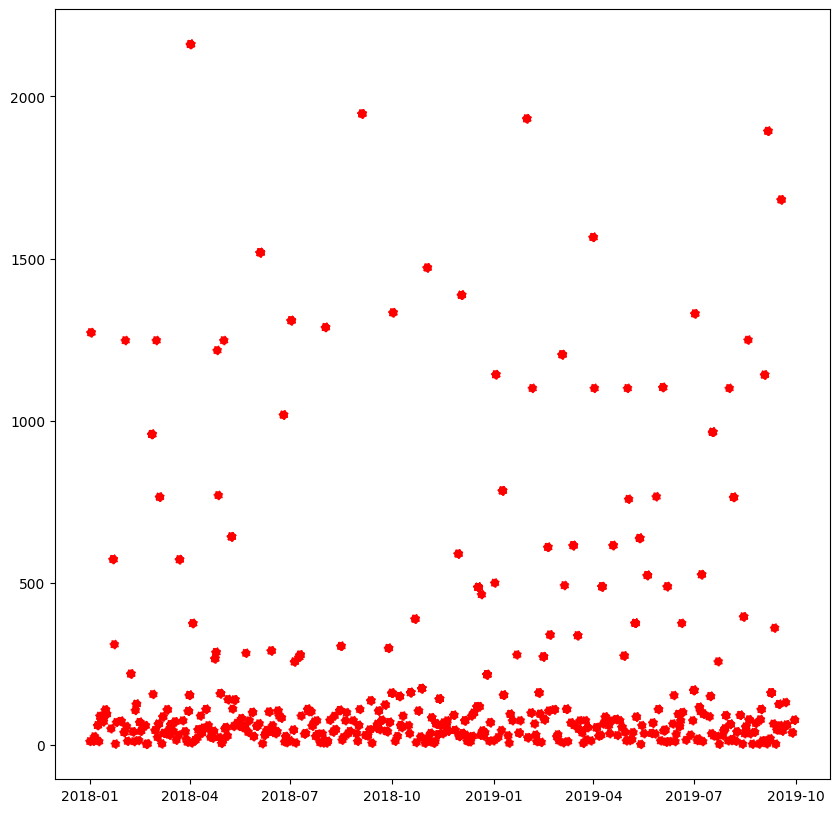

In [250]:
plt.figure(figsize=(10,10))
plt.scatter(df_sum['date'], df_sum['sum'], c="red", linestyle="dotted")
plt.show()

In [251]:
df_diff = df.copy()
df_diff['sum'] = df['sum'].diff()
df_diff['sum'][1] = df['sum'][1]
df_diff

,date,sum
1,2018-01-01,11.11
2,2018-01-02,1236.33
3,2018-01-02,-1223.22
5,2018-01-04,-12.46
6,2018-01-05,14.09
...,...,...
799,2019-09-23,-3.08
801,2019-09-28,8.83
802,2019-09-28,-29.19
803,2019-09-30,-2.52


# Обучение

In [252]:
def make_features(df):
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] > 4).astype('int16')
    
    df['is_winter'] = ((df['month'] >=12) & (df['month'] <= 2)).astype('int16')
    df['is_spring'] = ((df['month'] > 2) & (df['month'] <= 5)).astype('int16')
    df['is_summer'] = ((df['month'] > 5) & (df['month'] <= 8)).astype('int16')
    df['is_autumn'] = ((df['month'] > 8) & (df['month'] <= 11)).astype('int16')
    
    
    #return df.drop(columns=['date'])
    return df

In [253]:
ft = prepoc(df_sum)
display(ft)

,date,sum
1,2018-01-01,11.11
2,2018-01-02,1271.66
3,2018-01-02,1271.66
4,2018-01-04,11.76
5,2018-01-05,25.85
...,...,...
682,2019-09-23,61.77
683,2019-09-28,37.73
684,2019-09-28,37.73
685,2019-09-30,76.75


In [254]:
RANDOM_SEED = 5
EARLY_STOPPING_ROUND = 100

In [255]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

In [256]:
X_train, X_valid, y_train, y_valid = train_test_split(ft[['date', 'sum']], ft['sum'], test_size=0.2, shuffle=False)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
X_train = make_features(X_train)
X_eval = make_features(X_eval)
X_valid = make_features(X_valid)
display(X_train)

,date,sum,day,month,day_of_week,is_weekend,is_winter,is_spring,is_summer,is_autumn
1,2018-01-01,11.11,1,1,0,0,0,0,0,0
2,2018-01-02,1271.66,2,1,1,0,0,0,0,0
3,2018-01-02,1271.66,2,1,1,0,0,0,0,0
4,2018-01-04,11.76,4,1,3,0,0,0,0,0
5,2018-01-05,25.85,5,1,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
489,2019-03-23,5.20,23,3,5,1,0,1,0,0
490,2019-03-25,75.00,25,3,0,0,0,1,0,0
491,2019-03-26,16.04,26,3,1,0,0,1,0,0
492,2019-03-27,54.09,27,3,2,0,0,1,0,0


In [257]:
# выделим категориальные фичи для катбуста
CAT_COLUMNS = ['day', 'month', 'day_of_week', 'is_weekend', 'is_winter', 'is_spring', 'is_summer', 'is_autumn']

In [258]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    param['depth'] = trial.suggest_int('depth', 1, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise' #дерево строится шаг за шагом, пока не достигнет необходимой глубины. Листья разделяются с использованием условия, которое приводит к лучшему уменьшению потерь. 
    param['iterations'] = 100 # максимальное количество построенных деревьев
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter' # детектор переобучения: если кол-во итераций посли оптимального > od_wait, то модель переобучена
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent' # детализация вывода
    cat_features=CAT_COLUMNS
    
    regressor = cb.CatBoostRegressor(**param)

    regressor.fit(X_train.copy().drop(columns=['date', 'sum']), y_train.copy(),
                  eval_set=[(X_eval.copy().drop(columns=['date', 'sum']), y_eval.copy())],
                  early_stopping_rounds=EARLY_STOPPING_ROUND)
    loss = mean_squared_error(y_valid, regressor.predict(X_valid.copy().drop(columns=['date', 'sum'])), squared=False)
    return loss
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=2000, n_jobs=-1, timeout=24000, show_progress_bar=True)

[I 2023-05-29 23:00:09,634] A new study created in memory with name: catboost-seed5


  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2023-05-29 23:00:09,762] Trial 8 finished with value: 412.4823179544764 and parameters: {'learning_rate': 0.011, 'depth': 1, 'l2_leaf_reg': 4.5, 'min_child_samples': 16}. Best is trial 8 with value: 412.4823179544764.
[I 2023-05-29 23:00:09,781] Trial 6 finished with value: 414.0091843332554 and parameters: {'learning_rate': 0.007, 'depth': 1, 'l2_leaf_reg': 3.5, 'min_child_samples': 8}. Best is trial 8 with value: 412.4823179544764.
[I 2023-05-29 23:00:09,782] Trial 11 finished with value: 411.2708301697986 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 1, 'l2_leaf_reg': 3.0, 'min_child_samples': 8}. Best is trial 11 with value: 411.2708301697986.
[I 2023-05-29 23:00:09,798] Trial 7 finished with value: 393.2385587994944 and parameters: {'learning_rate': 0.008, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 1}. Best is trial 7 with value: 393.2385587994944.
[I 2023-05-29 23:00:09,798] Trial 10 finished with value: 415.00918033671184 and parameters: {'learnin

[I 2023-05-29 23:00:12,750] Trial 41 finished with value: 387.59779620003064 and parameters: {'learning_rate': 0.017, 'depth': 12, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:12,766] Trial 38 finished with value: 386.5969646779107 and parameters: {'learning_rate': 0.016, 'depth': 12, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:12,793] Trial 39 finished with value: 389.77918062635507 and parameters: {'learning_rate': 0.017, 'depth': 11, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:12,803] Trial 42 finished with value: 389.77918062635507 and parameters: {'learning_rate': 0.017, 'depth': 11, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:12,822] Trial 40 finished with value: 387.59779620003064 and parameters: {'learni

[I 2023-05-29 23:00:15,295] Trial 66 finished with value: 386.4251190016545 and parameters: {'learning_rate': 0.012, 'depth': 9, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:15,325] Trial 74 finished with value: 384.92503339416754 and parameters: {'learning_rate': 0.012, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:15,335] Trial 73 finished with value: 384.92503339416754 and parameters: {'learning_rate': 0.012, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:15,400] Trial 75 finished with value: 384.92503339416754 and parameters: {'learning_rate': 0.012, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:15,991] Trial 83 finished with value: 384.46688856821385 and parameters: {'learning_rate'

[I 2023-05-29 23:00:17,806] Trial 96 finished with value: 385.8990944935216 and parameters: {'learning_rate': 0.011, 'depth': 15, 'l2_leaf_reg': 2.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:17,822] Trial 99 finished with value: 385.89616056491724 and parameters: {'learning_rate': 0.011, 'depth': 15, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:19,057] Trial 115 finished with value: 390.4219972773317 and parameters: {'learning_rate': 0.008, 'depth': 14, 'l2_leaf_reg': 2.5, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:19,098] Trial 114 finished with value: 390.4219972773317 and parameters: {'learning_rate': 0.008, 'depth': 14, 'l2_leaf_reg': 2.5, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:19,118] Trial 119 finished with value: 390.4219972773317 and parameters: {'learning_

[I 2023-05-29 23:00:23,304] Trial 140 finished with value: 391.2431021638762 and parameters: {'learning_rate': 0.016, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:23,323] Trial 139 finished with value: 391.2431021638762 and parameters: {'learning_rate': 0.016, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:23,340] Trial 142 finished with value: 387.09886411335737 and parameters: {'learning_rate': 0.017, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:23,534] Trial 148 finished with value: 387.09886411335737 and parameters: {'learning_rate': 0.017, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:23,633] Trial 138 finished with value: 385.22658951126874 and parameters: {'learning_r

[I 2023-05-29 23:00:26,134] Trial 182 finished with value: 385.1204901394322 and parameters: {'learning_rate': 0.015, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:26,145] Trial 173 finished with value: 386.96768823134386 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:26,145] Trial 174 finished with value: 386.96768823134386 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:26,167] Trial 176 finished with value: 386.9804070956683 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 10, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 31 with value: 382.5794509793924.
[I 2023-05-29 23:00:26,754] Trial 187 finished with valu

[I 2023-05-29 23:00:28,649] Trial 221 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:28,651] Trial 226 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:28,672] Trial 229 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:28,680] Trial 223 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:28,680] Trial 227 finished with value: 383.70058249085594 and parameters: {'

[I 2023-05-29 23:00:30,883] Trial 258 finished with value: 386.6201994725362 and parameters: {'learning_rate': 0.016, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:30,903] Trial 267 finished with value: 385.4758426333146 and parameters: {'learning_rate': 0.017, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:30,906] Trial 261 finished with value: 385.4758426333146 and parameters: {'learning_rate': 0.017, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:30,926] Trial 264 finished with value: 387.9665214737292 and parameters: {'learning_rate': 0.017, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:30,932] Trial 262 finished with value: 385.4758426333146 and parameters: {'learn

[I 2023-05-29 23:00:33,355] Trial 298 finished with value: 410.5123180913795 and parameters: {'learning_rate': 0.017, 'depth': 1, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:33,484] Trial 304 finished with value: 385.9815589687378 and parameters: {'learning_rate': 0.017, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:33,504] Trial 294 finished with value: 385.9815589687378 and parameters: {'learning_rate': 0.017, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:33,512] Trial 293 finished with value: 386.01280979821854 and parameters: {'learning_rate': 0.016, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:33,545] Trial 300 finished with value: 385.9815589687378 and parameters: {'lear

[I 2023-05-29 23:00:35,783] Trial 330 finished with value: 382.859663924053 and parameters: {'learning_rate': 0.016, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:35,793] Trial 332 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:35,793] Trial 335 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:35,841] Trial 334 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:35,848] Trial 337 finished with value: 383.70058249085594 and parameters: {'le

[I 2023-05-29 23:00:37,972] Trial 366 finished with value: 383.50769766712324 and parameters: {'learning_rate': 0.017, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:37,991] Trial 370 finished with value: 386.3561032777149 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 3.0, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:38,007] Trial 372 finished with value: 388.5141569576353 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 5.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:38,022] Trial 375 finished with value: 388.5141569576353 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 5.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:38,022] Trial 368 finished with value: 387.3078270173383 and parameters: {'lear

[I 2023-05-29 23:00:40,298] Trial 408 finished with value: 384.52120991192834 and parameters: {'learning_rate': 0.016, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:40,326] Trial 406 finished with value: 384.52120991192834 and parameters: {'learning_rate': 0.016, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:40,342] Trial 409 finished with value: 390.1847117877664 and parameters: {'learning_rate': 0.007, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:40,342] Trial 404 finished with value: 384.52120991192834 and parameters: {'learning_rate': 0.016, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:40,342] Trial 405 finished with value: 382.859663924053 and parameters: {'lea

[I 2023-05-29 23:00:42,562] Trial 440 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:42,562] Trial 439 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:42,580] Trial 449 finished with value: 385.98446593733075 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:42,603] Trial 442 finished with value: 385.98446593733075 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:42,605] Trial 444 

[I 2023-05-29 23:00:44,074] Trial 464 finished with value: 386.4114390897834 and parameters: {'learning_rate': 0.015, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:44,826] Trial 474 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:44,835] Trial 477 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:44,886] Trial 482 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:44,888] Trial 475 finished with value: 385.984465

[I 2023-05-29 23:00:46,649] Trial 502 finished with value: 385.5103437697937 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:47,583] Trial 512 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:47,583] Trial 511 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:47,614] Trial 519 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:47,614] Trial 510 fi

[I 2023-05-29 23:00:49,903] Trial 552 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:49,938] Trial 556 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:49,961] Trial 548 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:49,977] Trial 549 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:49,978] Trial 553 fi

[I 2023-05-29 23:00:52,353] Trial 585 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:52,374] Trial 584 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:52,390] Trial 583 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:52,413] Trial 591 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 194 with value: 381.9472379280673.
[I 2023-05-29 23:00:52,415] Trial 589 fi

[I 2023-05-29 23:00:54,879] Trial 618 finished with value: 384.4300200533297 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:00:54,906] Trial 622 finished with value: 384.4300200533297 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:00:54,925] Trial 623 finished with value: 384.4300200533297 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:00:54,928] Trial 626 finished with value: 385.95634216270855 and parameters: {'learning_rate': 0.011, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:00:54,938] Trial 628 finished with value: 384.4300200533297 and parameters: {'lear

[I 2023-05-29 23:00:56,823] Trial 649 finished with value: 385.5674991383695 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 4.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:00:57,614] Trial 660 finished with value: 386.52000919203346 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:00:57,614] Trial 657 finished with value: 386.52000919203346 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:00:57,640] Trial 656 finished with value: 385.0163084314585 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 1.5, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:00:57,648] Trial 655 

[I 2023-05-29 23:01:00,307] Trial 690 finished with value: 385.1568844366752 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:00,337] Trial 695 finished with value: 386.5848527529107 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 4}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:00,345] Trial 700 finished with value: 386.5848527529107 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 4}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:00,357] Trial 701 finished with value: 385.98446593733075 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:00,368] Trial 694 finished with valu

[I 2023-05-29 23:01:03,456] Trial 726 finished with value: 386.40856617169413 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:03,494] Trial 731 finished with value: 384.9386653704595 and parameters: {'learning_rate': 0.015, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:03,494] Trial 729 finished with value: 384.9386653704595 and parameters: {'learning_rate': 0.015, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:03,505] Trial 732 finished with value: 384.9386653704595 and parameters: {'learning_rate': 0.015, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:03,522] Trial 730 finished with value: 384.9386653704595 and par

[I 2023-05-29 23:01:05,404] Trial 753 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:06,438] Trial 765 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:06,438] Trial 763 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:06,454] Trial 766 finished with value: 385.1568844366752 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:06,454] Trial 769 finished with value: 408.455831

[I 2023-05-29 23:01:09,405] Trial 809 finished with value: 395.98789573641494 and parameters: {'learning_rate': 0.015, 'depth': 2, 'l2_leaf_reg': 3.0, 'min_child_samples': 8}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:09,440] Trial 802 finished with value: 386.3561032777149 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 3.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:09,461] Trial 798 finished with value: 386.34723172889545 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 3.0, 'min_child_samples': 8}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:09,503] Trial 803 finished with value: 386.3561032777149 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 3.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:09,516] Trial 807 finished with value: 386.3561032777149 and para

[I 2023-05-29 23:01:11,604] Trial 824 finished with value: 385.5260016223929 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:11,607] Trial 822 finished with value: 384.83031783142343 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:12,639] Trial 834 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:12,670] Trial 837 finished with value: 385.98446593733075 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:12,703] Trial 840 

[I 2023-05-29 23:01:15,793] Trial 872 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:15,800] Trial 878 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:15,802] Trial 875 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:15,847] Trial 871 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:15,847] Trial 877 fi

[I 2023-05-29 23:01:19,249] Trial 915 finished with value: 387.9102971097191 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:19,283] Trial 916 finished with value: 386.99712688099055 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 1}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:19,296] Trial 909 finished with value: 384.65255191693007 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 1}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:19,313] Trial 913 finished with value: 386.0994907462506 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 5.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:19,316] Trial 912 fi

[I 2023-05-29 23:01:22,670] Trial 942 finished with value: 383.8409785719677 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:22,717] Trial 945 finished with value: 385.18714277945537 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:22,740] Trial 944 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:22,742] Trial 949 finished with value: 385.18714277945537 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:22,743] Trial 947 finished with value: 385.18714277945537 and 

[I 2023-05-29 23:01:25,921] Trial 981 finished with value: 386.36491321140414 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:25,921] Trial 980 finished with value: 387.9102971097191 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:25,940] Trial 978 finished with value: 387.9102971097191 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:25,956] Trial 982 finished with value: 386.36491321140414 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:25,970] Trial 986 

[I 2023-05-29 23:01:28,480] Trial 1005 finished with value: 384.4300200533297 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:28,483] Trial 1012 finished with value: 383.70058249085594 and parameters: {'learning_rate': 0.015, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:29,434] Trial 1022 finished with value: 385.98446593733075 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:29,434] Trial 1020 finished with value: 385.98446593733075 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:29,458] Trial 1019 finished with value: 385

[I 2023-05-29 23:01:31,827] Trial 1041 finished with value: 386.3185788368451 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:31,829] Trial 1044 finished with value: 386.3185788368451 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:31,829] Trial 1047 finished with value: 386.3185788368451 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:33,045] Trial 1051 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:33,083] Trial 10

[I 2023-05-29 23:01:35,797] Trial 1078 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:35,828] Trial 1084 finished with value: 385.15451496098376 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 9, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:36,806] Trial 1093 finished with value: 381.9472379280673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:36,806] Trial 1088 finished with value: 387.7875454836366 and parameters: {'learning_rate': 0.010000000000000002, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:36,824] Trial 1

[I 2023-05-29 23:01:39,412] Trial 1111 finished with value: 385.17170854451956 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 7, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:39,416] Trial 1114 finished with value: 386.20865686402686 and parameters: {'learning_rate': 0.015, 'depth': 7, 'l2_leaf_reg': 2.5, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:40,346] Trial 1130 finished with value: 411.8323614667836 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 1, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:40,435] Trial 1126 finished with value: 383.457148273347 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:40,457] Trial 1131 finished wi

[I 2023-05-29 23:01:42,947] Trial 1155 finished with value: 386.40856617169413 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:42,948] Trial 1153 finished with value: 386.3185788368451 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 4, 'l2_leaf_reg': 3.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:44,063] Trial 1160 finished with value: 395.8976354331904 and parameters: {'learning_rate': 0.015, 'depth': 2, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:44,079] Trial 1162 finished with value: 394.30176149378724 and parameters: {'learning_rate': 0.019000000000000003, 'depth': 2, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:44,148] Trial 1158 finished w

[I 2023-05-29 23:01:46,652] Trial 1185 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:46,653] Trial 1190 finished with value: 386.2904159425666 and parameters: {'learning_rate': 0.012, 'depth': 8, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:46,655] Trial 1183 finished with value: 386.2904159425666 and parameters: {'learning_rate': 0.012, 'depth': 8, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:47,876] Trial 1195 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:47,876] Trial 1201 finished with value: 384.38538502083867 and parameters:

[I 2023-05-29 23:01:50,843] Trial 1227 finished with value: 386.2247094029991 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:50,843] Trial 1225 finished with value: 386.2247094029991 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:50,851] Trial 1228 finished with value: 386.2247094029991 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:50,866] Trial 1221 finished with value: 386.2247094029991 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:50,940] Trial 12

[I 2023-05-29 23:01:54,773] Trial 1264 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:54,784] Trial 1262 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:54,784] Trial 1255 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:56,017] Trial 1268 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:56,027] Trial 1277 finished with value: 384.38538502083867

[I 2023-05-29 23:01:59,031] Trial 1300 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:59,039] Trial 1298 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:59,048] Trial 1293 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:01:59,051] Trial 1294 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:00,268] Trial 13

[I 2023-05-29 23:02:02,940] Trial 1334 finished with value: 387.8653157309716 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.5, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:02,940] Trial 1333 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:02,940] Trial 1337 finished with value: 383.8557205412708 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:04,243] Trial 1343 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:04,287] Trial 13

[I 2023-05-29 23:02:07,383] Trial 1366 finished with value: 386.2247094029991 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:07,384] Trial 1370 finished with value: 388.3448328945505 and parameters: {'learning_rate': 0.011, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:08,627] Trial 1379 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:08,654] Trial 1376 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:08,671] Trial 1384 finished wit

[I 2023-05-29 23:02:11,565] Trial 1405 finished with value: 384.6859833426083 and parameters: {'learning_rate': 0.012, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:11,567] Trial 1409 finished with value: 384.6859833426083 and parameters: {'learning_rate': 0.012, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:12,876] Trial 1412 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:12,876] Trial 1417 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:12,928] Trial 1413 finished with value: 381.78

[I 2023-05-29 23:02:15,860] Trial 1442 finished with value: 383.7309834760953 and parameters: {'learning_rate': 0.012, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 8}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:15,862] Trial 1438 finished with value: 383.7309834760953 and parameters: {'learning_rate': 0.012, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 8}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:15,871] Trial 1445 finished with value: 383.7309834760953 and parameters: {'learning_rate': 0.012, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 8}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:17,176] Trial 1456 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:17,176] Trial 1454 finished with value: 387.7896015126659 and pa

[I 2023-05-29 23:02:20,041] Trial 1471 finished with value: 385.9014280052411 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:20,041] Trial 1479 finished with value: 384.6859833426083 and parameters: {'learning_rate': 0.012, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:20,041] Trial 1478 finished with value: 384.6859833426083 and parameters: {'learning_rate': 0.012, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:21,527] Trial 1485 finished with value: 387.8653157309716 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.5, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:21,567] Trial 1484 finished with value: 387.86

[I 2023-05-29 23:02:24,663] Trial 1513 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:24,663] Trial 1516 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:24,664] Trial 1517 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:25,979] Trial 1521 finished with value: 388.70401707208026 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 3, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:25,981] Trial 1518 finished with value: 387.9893487015753

[I 2023-05-29 23:02:29,054] Trial 1549 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:29,055] Trial 1551 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:30,440] Trial 1556 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:30,459] Trial 1561 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:30,461] Trial 1554 finished with value: 384.

[I 2023-05-29 23:02:34,928] Trial 1591 finished with value: 385.75818186570984 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:34,928] Trial 1599 finished with value: 386.4738146438005 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:34,939] Trial 1595 finished with value: 386.4738146438005 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 32}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:35,001] Trial 1590 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:35,008] Trial 1598 finished with value: 384.3

[I 2023-05-29 23:02:39,825] Trial 1629 finished with value: 385.1209685341319 and parameters: {'learning_rate': 0.012, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:39,825] Trial 1630 finished with value: 396.1603321559514 and parameters: {'learning_rate': 0.005, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:39,845] Trial 1627 finished with value: 385.1209685341319 and parameters: {'learning_rate': 0.012, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:39,847] Trial 1634 finished with value: 385.1209685341319 and parameters: {'learning_rate': 0.012, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:39,874] Trial 1636 finished with value: 385.1209685341319 and parameters: {'

[I 2023-05-29 23:02:44,575] Trial 1672 finished with value: 384.6859833426083 and parameters: {'learning_rate': 0.012, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:44,611] Trial 1664 finished with value: 384.6859833426083 and parameters: {'learning_rate': 0.012, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:44,645] Trial 1667 finished with value: 384.6859833426083 and parameters: {'learning_rate': 0.012, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:44,653] Trial 1665 finished with value: 384.6859833426083 and parameters: {'learning_rate': 0.012, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:44,666] Trial 1663 finished with value: 385.9014280052411 and parameters: {'

[I 2023-05-29 23:02:49,231] Trial 1699 finished with value: 387.5438099208395 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:49,231] Trial 1703 finished with value: 387.9782773856553 and parameters: {'learning_rate': 0.012, 'depth': 4, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:49,257] Trial 1698 finished with value: 386.2247094029991 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:49,257] Trial 1700 finished with value: 387.5438099208395 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:49,294] Trial 1704 finished wit

[I 2023-05-29 23:02:54,129] Trial 1735 finished with value: 388.70401707208026 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 3, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:54,131] Trial 1741 finished with value: 388.70401707208026 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 3, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:54,140] Trial 1744 finished with value: 388.70401707208026 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 3, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:54,170] Trial 1743 finished with value: 388.70401707208026 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 3, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:54,231] Tria

[I 2023-05-29 23:02:59,087] Trial 1777 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:59,102] Trial 1775 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:59,113] Trial 1778 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:59,114] Trial 1776 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:02:59,141] Trial 1780 finished with value: 384.38538502083867 and parameter

[I 2023-05-29 23:03:02,492] Trial 1799 finished with value: 387.25271188349194 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 8}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:03,896] Trial 1817 finished with value: 396.55633230987917 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 2, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:03,896] Trial 1814 finished with value: 396.55633230987917 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 2, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:03,997] Trial 1808 finished with value: 383.8557205412708 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:03,997] Trial 

[I 2023-05-29 23:03:09,207] Trial 1844 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:09,209] Trial 1846 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:09,239] Trial 1843 finished with value: 384.54353248382324 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:09,277] Trial 1845 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:09,278] Trial 1

[I 2023-05-29 23:03:14,280] Trial 1880 finished with value: 411.21450671120266 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 1, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:14,370] Trial 1884 finished with value: 384.54353248382324 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:14,396] Trial 1886 finished with value: 384.54353248382324 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:14,443] Trial 1883 finished with value: 384.54353248382324 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:14,451] Tria

[I 2023-05-29 23:03:19,512] Trial 1921 finished with value: 385.9014280052411 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:19,520] Trial 1918 finished with value: 385.9014280052411 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:19,520] Trial 1914 finished with value: 385.9014280052411 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:19,576] Trial 1916 finished with value: 385.9014280052411 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:19,599] Trial 19

[I 2023-05-29 23:03:22,932] Trial 1949 finished with value: 384.54353248382324 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:22,932] Trial 1943 finished with value: 384.54353248382324 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:22,951] Trial 1945 finished with value: 384.54353248382324 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:24,501] Trial 1953 finished with value: 386.2247094029991 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:24,522] Trial

[I 2023-05-29 23:03:28,497] Trial 1985 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:28,501] Trial 1974 finished with value: 384.38538502083867 and parameters: {'learning_rate': 0.012, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:28,523] Trial 1976 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:28,525] Trial 1978 finished with value: 381.7830714326276 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 5, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 612 with value: 381.7830714326276.
[I 2023-05-29 23:03:28,576] Trial 1983 finished wi

In [259]:
study.best_params

{'learning_rate': 0.013000000000000001,
 'depth': 5,
 'l2_leaf_reg': 1.0,
 'min_child_samples': 16}

In [260]:
try:
    os.mkdir(f"models") # создаем папку для сохранения моделей
except:
    pass

In [261]:
optimized_regressor = cb.CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
                                        depth=study.best_params['depth'],
                                        l2_leaf_reg=study.best_params['l2_leaf_reg'],
                                        min_child_samples=study.best_params['min_child_samples'],
                                        grow_policy='Depthwise',
                                        iterations=100,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=RANDOM_SEED,
                                        logging_level='Silent',
                                       cat_features=CAT_COLUMNS)
optimized_regressor.fit(X_train.copy().drop(columns=['date', 'sum']), y_train.copy(),
                        eval_set=[(X_eval.copy().drop(columns=['date', 'sum']), y_eval.copy())],
                        early_stopping_rounds=EARLY_STOPPING_ROUND)
pred_train = optimized_regressor.predict(X_train.copy().drop(columns=['date', 'sum']))
pred_valid = optimized_regressor.predict(X_valid.copy().drop(columns=['date', 'sum']))
with open(f"models/model_catboost.pkl", 'wb') as f:
        pickle.dump(optimized_regressor, f)

In [262]:
# параметры для lama
N_THREADS = 40
N_FOLDS = 3
RANDOM_STATE = 56
TEST_SIZE = 0.2
TIMEOUT = 60*2


np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

task = Task('reg')

In [241]:
# функция для обучения и подсчета метрики lama
def fit_predict_lama(X_train, y_train, X_val, y_val):
    scores = []
    TARGET_NAME = 'sum'
    roles = {
        'target': TARGET_NAME,
    }
    automl = TabularUtilizedAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE})
    oof_pred = automl.fit_predict(X_train, roles=roles, verbose=False)
    preds = automl.predict(X_val)
    scores.append(rmse(y_val, preds.data[:, 0]))
    with open(f"models/model_lama.pkl", 'wb') as f:
        pickle.dump(automl, f)
    print(scores[-1])
    return [scores, preds]

In [242]:
[scores_lama, predict_lama] = fit_predict_lama(X_train.copy(), y_train.copy(), X_valid.copy(), y_valid.copy())

[I 2023-05-29 22:52:43,370] A new study created in memory with name: no-name-4344ef2b-2422-403b-92f8-c1aa9b6bc224
[I 2023-05-29 22:52:44,538] Trial 0 finished with value: -74695.44956782553 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -74695.44956782553.
[I 2023-05-29 22:52:45,657] Trial 1 finished with value: -76042.4402383065 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: -74695.44956782553.
[I 2023-05-29 22:52:46,160] Trial 2 finished with value: -93032.69179857097 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fracti

[I 2023-05-29 22:53:02,873] Trial 22 finished with value: -72920.82548470299 and parameters: {'feature_fraction': 0.646817641645387, 'num_leaves': 102, 'bagging_fraction': 0.8388581859353572, 'min_sum_hessian_in_leaf': 0.12948797718087005, 'reg_alpha': 1.155943557022699e-07, 'reg_lambda': 1.3469674210815906e-08}. Best is trial 12 with value: -72303.93140292216.
[I 2023-05-29 22:53:04,071] Trial 23 finished with value: -73289.86313859379 and parameters: {'feature_fraction': 0.694403423678129, 'num_leaves': 146, 'bagging_fraction': 0.8962657884520717, 'min_sum_hessian_in_leaf': 0.041332069094414586, 'reg_alpha': 1.7370097104562699e-06, 'reg_lambda': 9.906414046681161e-08}. Best is trial 12 with value: -72303.93140292216.
[I 2023-05-29 22:53:05,876] A new study created in memory with name: no-name-be798330-254f-4109-bd58-42138990459e
[I 2023-05-29 22:53:06,361] Trial 0 finished with value: -62657.09390154709 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_

[I 2023-05-29 22:53:28,534] Trial 32 finished with value: -51107.01924018781 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.007969514521661121, 'min_data_in_leaf': 12}. Best is trial 16 with value: -50209.820439069445.
[I 2023-05-29 22:53:28,966] Trial 33 finished with value: -50720.590717215935 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.009854061822366039, 'min_data_in_leaf': 6}. Best is trial 16 with value: -50209.820439069445.
[I 2023-05-29 22:53:29,438] Trial 34 finished with value: -51137.41251232563 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.23348725539622214, 'min_data_in_leaf': 14}. Best is trial 16 with value: -50209.820439069445.
[I 2023-05-29 22:53:30,268] Trial 35 finished with value: -52413.60922656423 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.022533580482228307, 'min_data_in_leaf': 9}. Best is trial 16 with value: -50209.820439069445.
[I 2023-05-29 22:53:31,308] Trial 36 finished with value: -58761.0386311811 and parameters: {'max_depth': 6, 'l2_l

[I 2023-05-29 22:53:50,957] Trial 67 finished with value: -51115.00037035127 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.004063443239617967, 'min_data_in_leaf': 9}. Best is trial 16 with value: -50209.820439069445.
[I 2023-05-29 22:53:51,737] Trial 68 finished with value: -50996.92024366932 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.010796046672328696, 'min_data_in_leaf': 5}. Best is trial 16 with value: -50209.820439069445.
[I 2023-05-29 22:53:52,808] Trial 69 finished with value: -57679.81547741505 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0005545097888763514, 'min_data_in_leaf': 4}. Best is trial 16 with value: -50209.820439069445.
[I 2023-05-29 22:53:53,410] Trial 70 finished with value: -50601.686473534806 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0693896537901323, 'min_data_in_leaf': 12}. Best is trial 16 with value: -50209.820439069445.
[I 2023-05-29 22:53:54,187] Trial 71 finished with value: -51540.65227247414 and parameters: {'max_depth': 7, 'l2_l

392.17835711212354


# Предсказание

In [263]:
def make_features(df):
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] > 4).astype('int16')
    
    df['is_winter'] = ((df['month'] >=12) & (df['month'] <= 2)).astype('int16')
    df['is_spring'] = ((df['month'] > 2) & (df['month'] <= 5)).astype('int16')
    df['is_summer'] = ((df['month'] > 5) & (df['month'] <= 8)).astype('int16')
    df['is_autumn'] = ((df['month'] > 8) & (df['month'] <= 11)).astype('int16')  
    
    #return df.drop(columns=['date'])
    return df

In [264]:
def make_preds(df, y, model_dir):
    res = dict()
    res['sum'] = df['sum']
    res['date'] = df['date']
    targets = os.listdir(model_dir)
    good_df = df.copy()
    display(good_df)
    for target in targets:
        if target == 'model_catboost.pkl':
            model = [pickle.load(open(f"{model_dir}/{target}", 'rb'))][0]
            preds = model.predict(good_df.drop(columns=['date', 'sum']))
            res[target] = preds
        elif target == 'model_lama.pkl':
            model = [pickle.load(open(f"{model_dir}/{target}", 'rb'))][0]
            preds = model.predict(good_df.drop(columns=['sum']))
            res[target] = preds.data[:, 0]
    return pd.DataFrame(res)

res = make_preds(X_valid, y_valid, 'models')
res

,date,sum,day,month,day_of_week,is_weekend,is_winter,is_spring,is_summer,is_autumn
549,2019-05-24,35.96,24,5,4,0,0,1,0,0
550,2019-05-24,35.96,24,5,4,0,0,1,0,0
551,2019-05-25,67.75,25,5,5,1,0,1,0,0
552,2019-05-25,67.75,25,5,5,1,0,1,0,0
553,2019-05-27,34.33,27,5,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
682,2019-09-23,61.77,23,9,0,0,0,0,0,1
683,2019-09-28,37.73,28,9,5,1,0,0,0,1
684,2019-09-28,37.73,28,9,5,1,0,0,0,1
685,2019-09-30,76.75,30,9,0,0,0,0,0,1


,sum,date,model_catboost.pkl,model_lama.pkl
549,35.96,2019-05-24,168.437048,150.992645
550,35.96,2019-05-24,168.437048,150.992645
551,67.75,2019-05-25,318.978653,67.911148
552,67.75,2019-05-25,318.978653,67.911148
553,34.33,2019-05-27,211.460582,126.735855
...,...,...,...,...
682,61.77,2019-09-23,239.814345,174.216843
683,37.73,2019-09-28,118.722814,121.789413
684,37.73,2019-09-28,118.722814,121.789413
685,76.75,2019-09-30,228.597131,207.767242


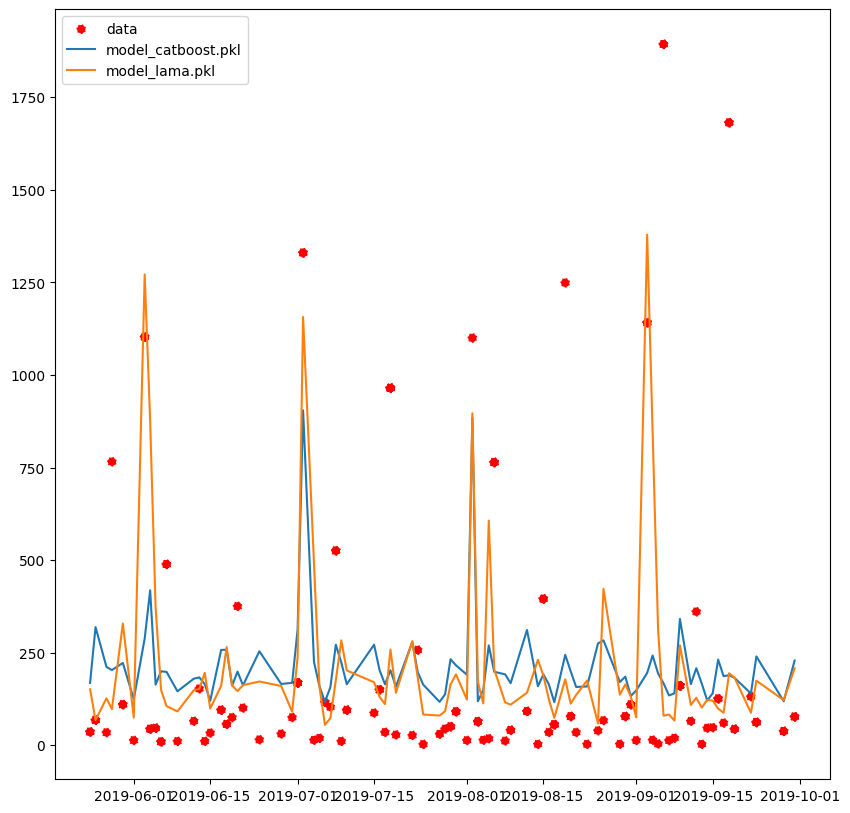

In [265]:
targets = os.listdir('models')
plt.figure(figsize=(10,10))
plt.scatter(res['date'], res['sum'], c="red", linestyle="dotted")
for target in targets:
    plt.plot(res['date'], res[target])
plt.legend(['data'] + targets)